## Exploratory Data Analysis on Diabetes dataset using PySpark

In [1]:
import pyspark
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

In [2]:
spark=SparkSession.builder.appName("EDA").getOrCreate()

In [3]:
df=spark.read.csv("diabetes.csv",inferSchema=True,header=True)

df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [4]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [5]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

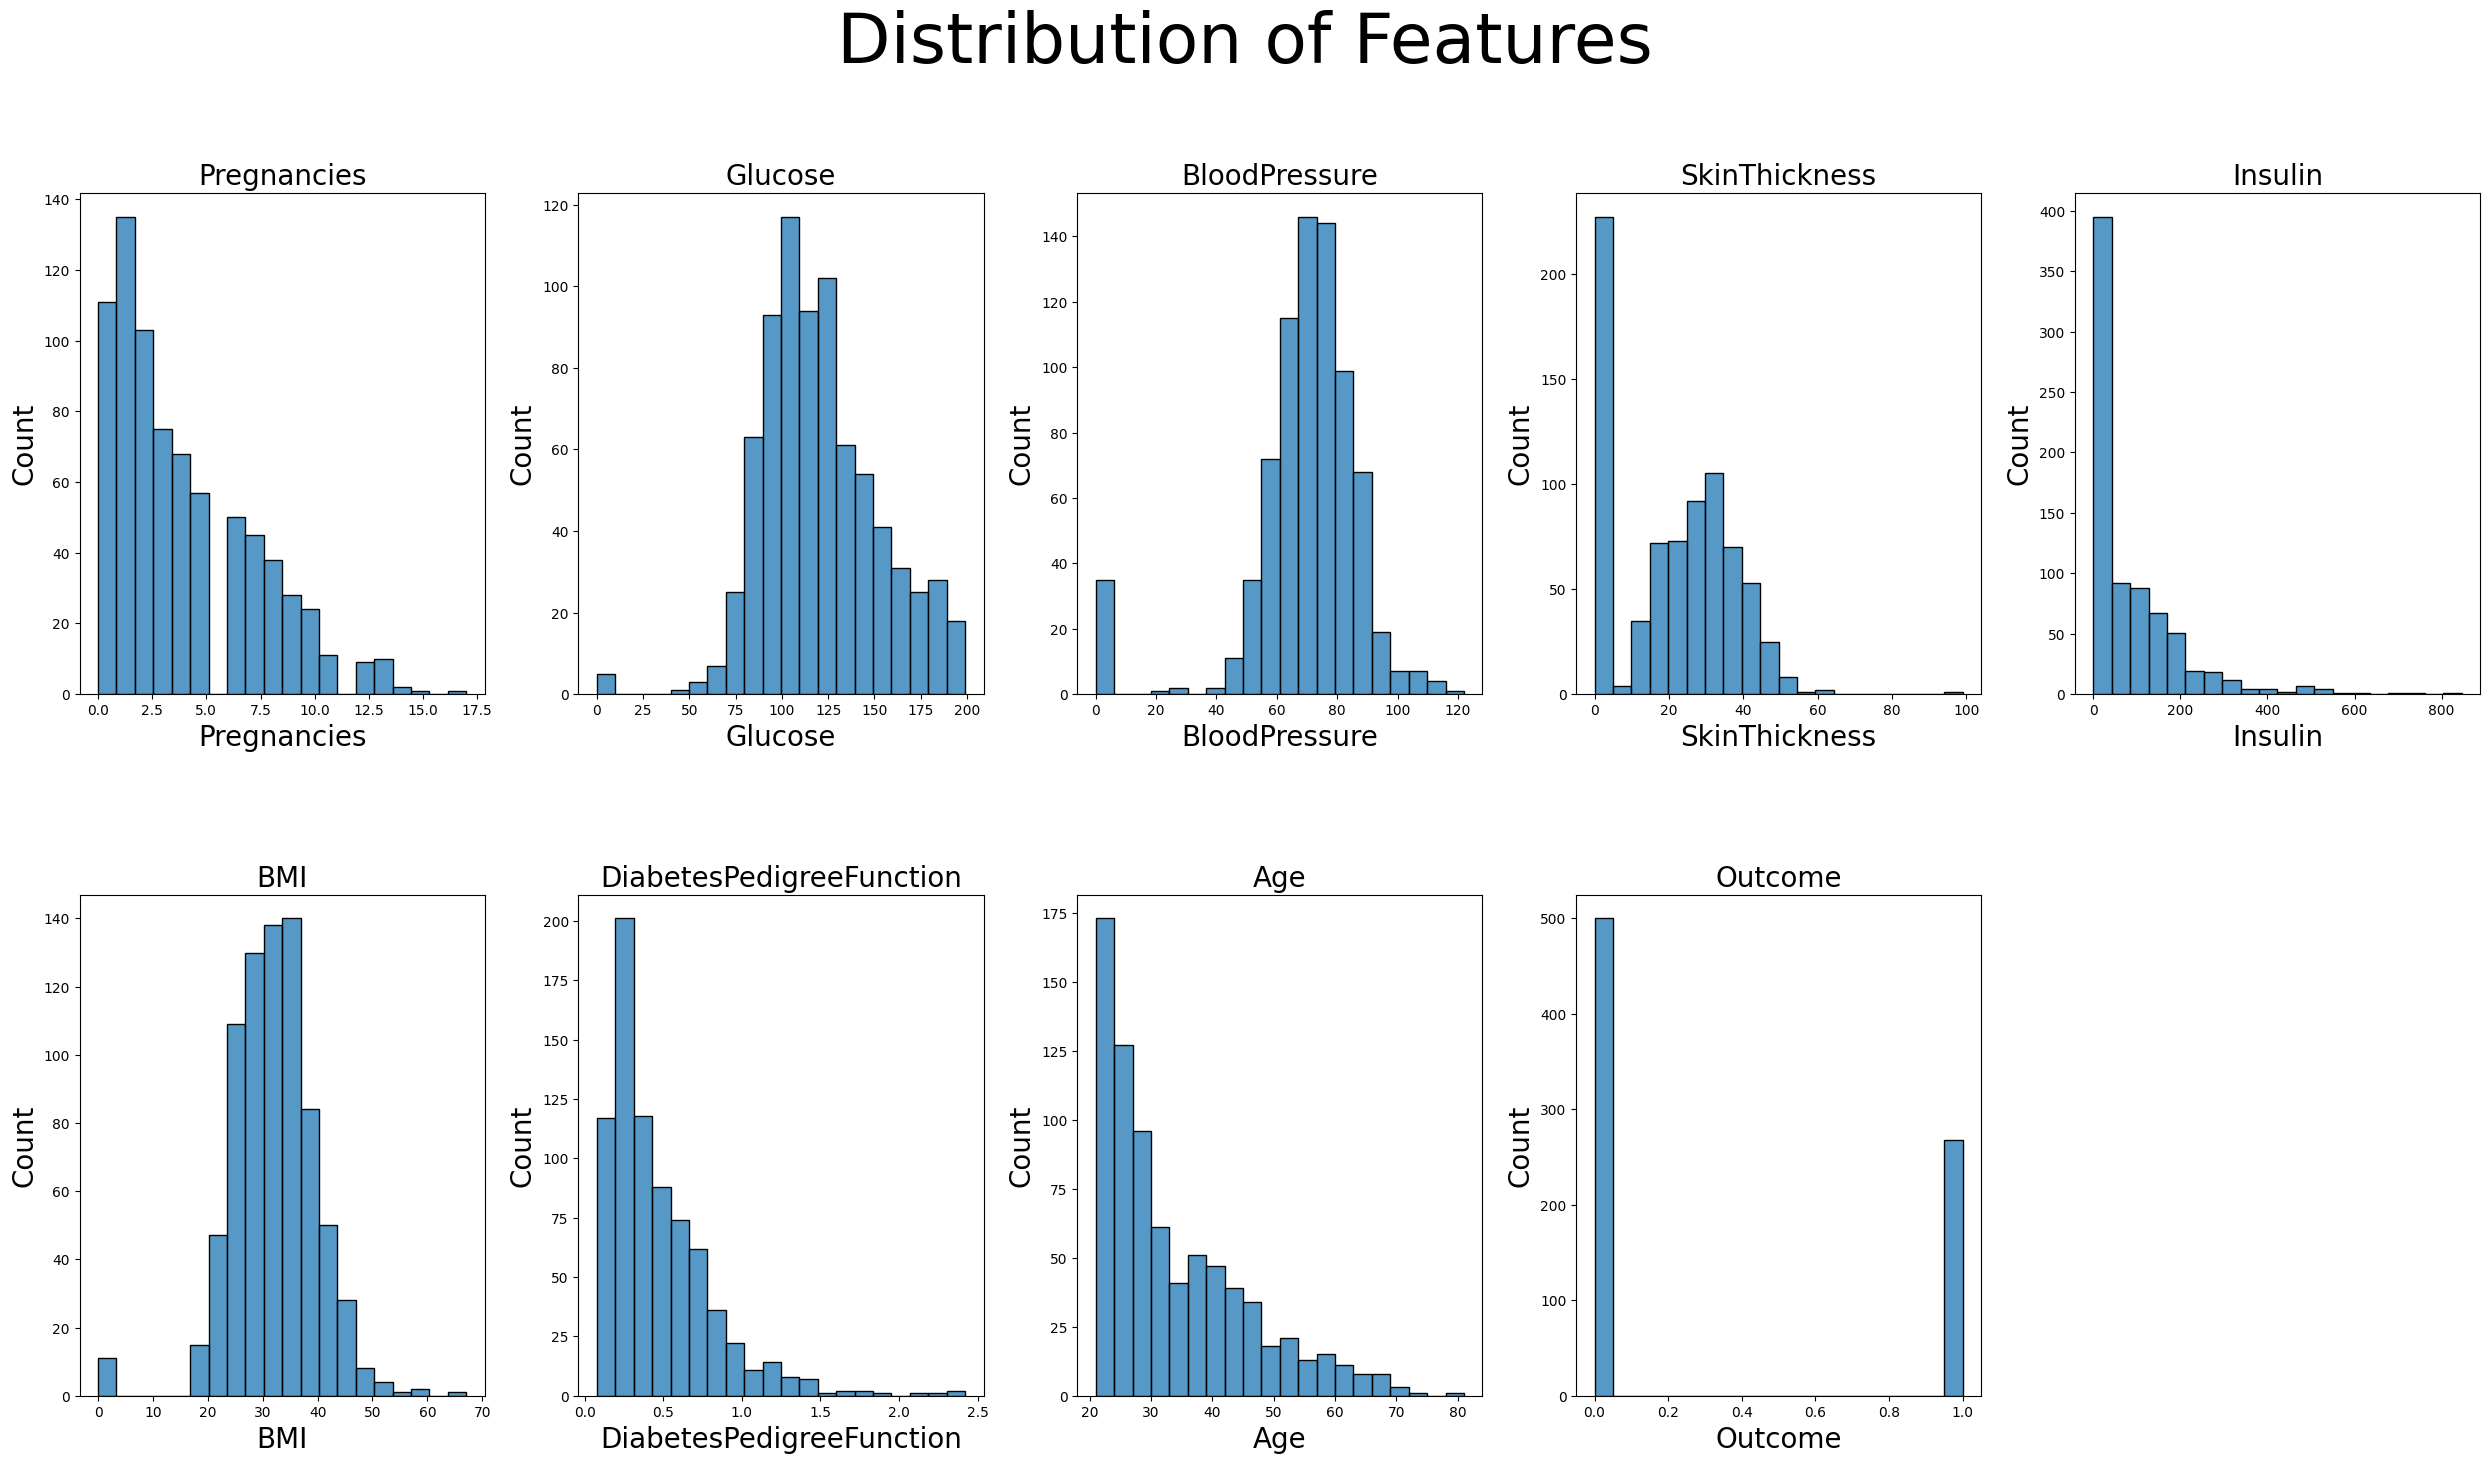

In [7]:
fig=plt.figure(figsize=(25, 15))
st=fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for cols, num in zip(df.toPandas().describe().columns, range(1, 11)):
    ax = fig.add_subplot(2, 5, num)
    sns.histplot(df.toPandas()[cols], bins=20, ax=ax)
    ax.set_title(cols, fontsize=20)
    ax.set_xlabel(cols, fontsize=20)
    ax.set_ylabel("Count", fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [8]:
from pyspark.sql.functions import isnan, when, count, col

In [9]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [10]:
#user defined function(udf)

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [11]:
y_udf=udf(lambda y: "no" if y==0 else "yes", StringType())

In [12]:
df=df.withColumn("HasDiabetes", y_udf('Outcome')).drop("Outcome")
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 5 rows



In [27]:
def udf_multi(age):
    if (age<25):
        return "Under 25"
    elif (age>=25 and age<=35):
        return "Between 25 and 35"
    elif (age>35 and age<50):
        return "Between 36 and 50"
    elif (age>=50):
        return "Over 50"
    else: return "NA"


In [28]:
age_udf=udf(udf_multi)
df=df.withColumn('age_udf', age_udf("Age"))

In [29]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|         Under 25|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|Between 25 and 35|
+-----------+-------+---

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, desc
from pyspark.sql import Window

In [17]:
window=Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [24]:
age_group_tab=df.select(["age_udf", "Glucose"]).groupBy('age_udf').\
                                      agg(
                                          F.count("Glucose").alias("UserCount"),
                                          F.mean("Glucose").alias("Glucose_AVG"),
                                          F.stddev("Glucose").alias("Glucose_Std"),
                                          
                                          F.min("Glucose").alias("Glucose_Min"),
                                          F.max("Glucose").alias("Glucose_Max"),
                                          
                                          F.skewness("Glucose").alias("Skewness"),
                                          F.kurtosis("Glucose").alias("Kurtosis"),
                                          F.var_pop("Glucose").alias("Variance"),
                                          F.percentile_approx("Glucose", 0.5).alias("Median")).\
                                withColumn('total', sum(col('Usercount')).over(window)).withColumn('Percent', col('UserCount')*100/col('total')).\
                                drop(col('total')).sort(desc('Percent'))       
                                              

In [30]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_AVG,Glucose_Std,Glucose_Min,Glucose_Max,Skewness,Kurtosis,Variance,Median,Percent
0,Under 25,267,110.719101,29.360985,0,199,0.19360,1.982622,858.838699,107,34.765625
1,Between 25 and 35,231,121.670996,28.286653,71,198,0.73758,-0.039352,796.670977,117,30.078125
2,Between 36 and 50,181,125.740331,35.424316,0,197,-0.31895,0.620651,1247.949147,125,23.567708
3,Over 50,89,139.550562,30.494788,57,197,0.05941,-0.493696,919.483399,138,11.588542


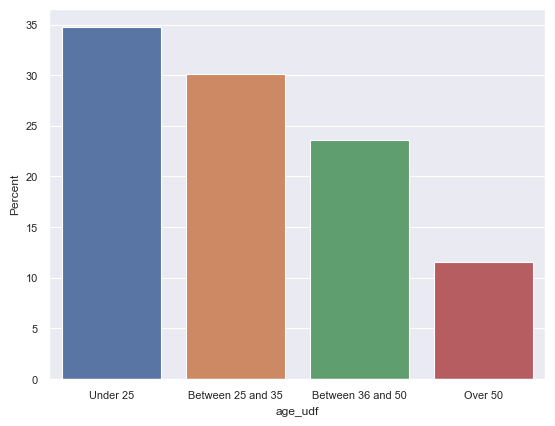

In [52]:
sns.barplot(x="age_udf", y="Percent", data=age_group_tab.toPandas())
sns.set_context("paper", font_scale=1.1)

In [34]:
#Correlation

num_features=[t[0] for t in df.dtypes if t[1] != 'string']
num_features_df=df.select(num_features)
num_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [35]:
col_names=num_features_df.columns
features=num_features_df.rdd.map(lambda row: row[0:])


In [36]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [40]:
corr_maths=Statistics.corr(features, method='pearson')
corr_df=pd.DataFrame(corr_maths)

corr_df.index=col_names

corr_df.columns=col_names

round(corr_df, 2)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


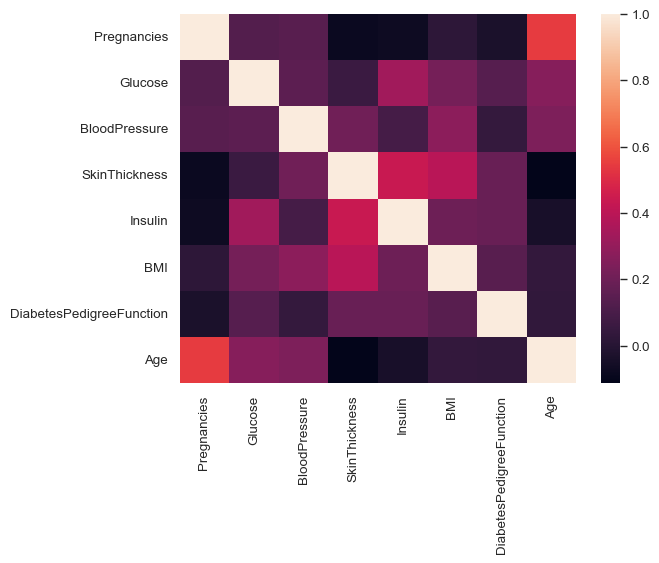

In [53]:
sns.heatmap(corr_df)
sns.set_context("paper", font_scale=1.2)